<a href="https://colab.research.google.com/github/alracey/level4-project/blob/main/1d_piecewise_extended.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapezoid

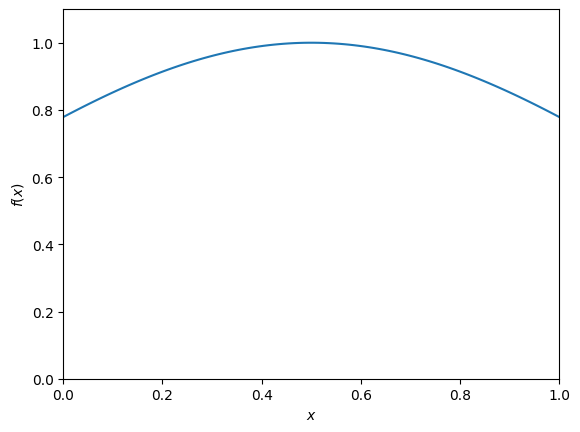

In [2]:
def f(x):
  return np.exp(-(x-0.5)**2)

xs = np.linspace(0, 1, 100)
f_evals = f(xs)
plt.plot(xs, f_evals)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(0, 1)
plt.ylim(0, 1.1)
plt.show()

In [12]:
K = 5    #NUMBER OF BINS

x_bins = np.linspace(0, 1, K+1)   #edges

y_initial = np.linspace(0, 1, K+1)    #(K+1) heights; (K-1) parameters
params_0 = y_initial[1:-1]


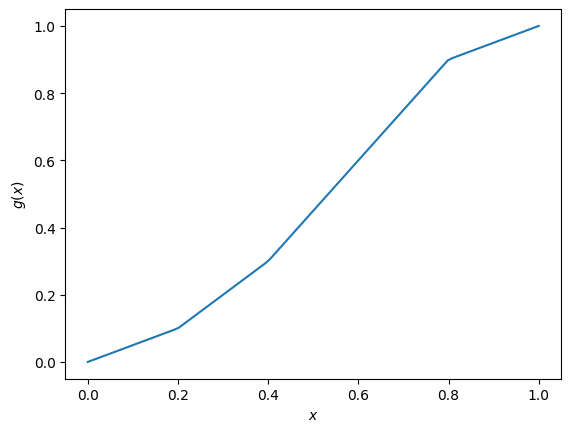

In [15]:
def g_new(x, y_params):
  #using given params, append 0 and 1 to the ends
  ys = np.concatenate(([0.0], y_params, [1.0]))

  #find the correct bin indices i for each x value
  i_values = np.minimum((x*K).astype(int), K-1) # Ensures indices are within the valid range [0, K-1]

  #compute the edges
  x_left = x_bins[i_values]
  x_right = x_bins[i_values + 1]
  y_left = ys[i_values]
  y_right = ys[i_values + 1]

  #compute the linear mappings for all x

  return y_left + ((y_right - y_left) / (x_right - x_left)) * (x - x_left)

test = g_new(xs, np.array([0.1, 0.3, 0.6, 0.9]))
plt.plot(xs, test)
plt.xlabel("$x$")
plt.ylabel("$g(x)$")
plt.show()

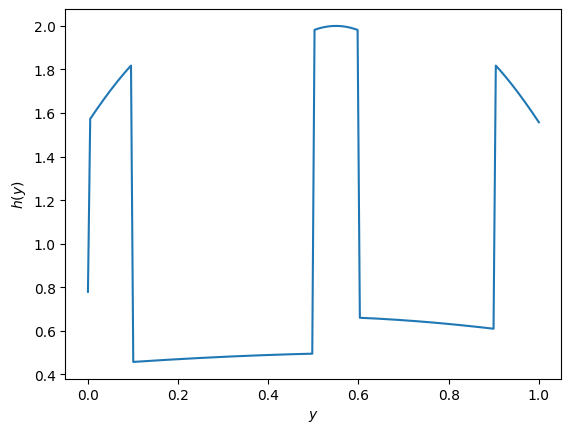

In [20]:
def transformed_f_new(y, y_params):


  #using given params, append 0 and 1 to the ends
  ys = np.concatenate(([0.0], y_params, [1.0]))

  #find the correct bin indices i for each y value
  j_values = np.minimum((np.searchsorted(ys, y) - 1), K - 1)    # Ensures indices are within the valid range [0, K-1]

  #compute the edges
  x_left = x_bins[j_values]
  x_right = x_bins[j_values + 1]
  y_left = ys[j_values]
  y_right = ys[j_values + 1]

  def g_inv_new(y):

    return x_left + ((x_right - x_left) / (y_right - y_left)) * (y - y_left)

  def jacobians(x_left, x_right, y_left, y_right):

    return (x_right - x_left) / (y_right - y_left)

  arg = g_inv_new(y)
  jac = jacobians(x_left, x_right, y_left, y_right)

  return f(arg) * jac


y_test = np.linspace(0, 1, 200)
test_params = np.array([0.1, 0.5, 0.6, 0.9])
transform_test = transformed_f_new(y_test, test_params)

plt.plot(y_test, transform_test)
plt.xlabel("$y$")
plt.ylabel("$h(y)$")
plt.show()

In [26]:
#integration preservation checks

x_int_test, y_int_test = np.linspace(0, 1, 10000), np.linspace(0, 1, 1000000)
h_test_params = np.array([0.1, 0.4, 0.5, 0.8])

f_evals_test = f(x_int_test)
F = trapezoid(f_evals_test, x_int_test)
print("Trapezoid method: F = ", F)
F_q = quad(lambda x: f(x), 0, 1)
print("Quad method: F = ", F_q[0])

H_evals_test = transformed_f_new(y_int_test, h_test_params)
H = trapezoid(H_evals_test, y_int_test)
print("Trapezoid method: H = ", H)
H_q = quad(lambda y: transformed_f_new(y, h_test_params), 0, 1)
print("Quad method: H = ", H_q[0])

Trapezoid method: F =  0.922562011527324
Quad method: F =  0.9225620128255849
Trapezoid method: H =  0.9225611766077242
Quad method: H =  0.9225620128240943


In [16]:
y_bins = np.array([0.0, 0.1, 0.3, 0.6, 0.9, 1.0])
y = np.array([0.05, 0.2, 0.4, 0.8])
print(np.searchsorted(y_bins, y))


[1 2 3 4]
